In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In this notebook, we compute the maximal (resp. minimal) controlled invariant set contained in the square with vertices $(\pm 1, \pm 1)$ for the system
$$\begin{align*}
v_{k+1} & = v_k + a_k \Delta t\\
a_{k+1} & = u_k
\end{align*}$$
using the technique developed in [LTJ18].

The system is $x_{k+1} = Ax_k + Bu_k$ where $B = (0, 1)$ and
$$
A = \begin{bmatrix}
1 & \Delta t\\
0 & 0
\end{bmatrix}.
$$
As shown in [LTJ18], a set $S$ is controlled invariant if
$$
\begin{bmatrix}
1 & \Delta t
\end{bmatrix}
S \subseteq
\begin{bmatrix}
1 & 0
\end{bmatrix}
S
$$

[LTJ18] B. Legat, P. Tabuada and R. M. Jungers.
*Computing controlled invariant sets for hybrid systems with applications to model-predictive control*.
6th IFAC Conference on Analysis and Design of Hybrid Systems ADHS 2018, **2018**.

In [2]:
using Polyhedra
h = HalfSpace([1, 0], 1.0) ∩ HalfSpace([-1, 0], 1) ∩ HalfSpace([0, 1], 1) ∩ HalfSpace([0, -1], 1)
□ = polyhedron(h);

We need to pick an SDP solver, see [here](http://www.juliaopt.org/JuMP.jl/dev/installation/#Getting-Solvers-1) for a list of available ones. Run one of the following two cells to choose choose the solver.

In [ ]:
using SCS
using SetProg
factory = with_optimizer(SCS.Optimizer, verbose=0);

In [ ]:
using CSDP    # CSDP is less appropriate than SCS and Mosek because it does not natively support
using SetProg # SOC constraints so they need to be bridged to SDP constraints.
factory = with_optimizer(CSDP.Optimizer, printlevel=0); # SOC constraints are needed for the nth_root

In [3]:
using MosekTools
using SetProg
factory = with_optimizer(Mosek.Optimizer, LOG=0);

In [4]:
Δt = 0.5
A = [1.0 Δt]
E = [1.0 0.0]

1×2 Array{Float64,2}:
 1.0  0.0

In [5]:
model = Model(factory);
@variable(model, S, Ellipsoid(symmetric=true))
@constraint(model, S ⊆ □)
@constraint(model, A * S ⊆ E * S)
@objective(model, Max, nth_root(volume(S)))
@time JuMP.optimize!(model)
@show JuMP.termination_status(model)
@show JuMP.objective_value(model);
ell = JuMP.value(S)

 21.464501 seconds (73.45 M allocations: 3.733 GiB, 8.74% gc time)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 0.9682458135642293


SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([1.0 -0.25; -0.25 1.0]))

In [6]:
function Sd(d)
    model = Model(factory);
    @variable(model, S, PolySet(degree=d, convex=true, symmetric=true))
    @constraint(model, S ⊆ □)
    @constraint(model, A * S ⊆ E * S)
    @objective(model, Max, L1_heuristic(volume(S), [1.0, 1.0]))
    @time JuMP.optimize!(model)
    @show JuMP.termination_status(model)
    @show JuMP.objective_value(model)
    #display(MOI.get(model.moi_backend, MOI.VariablePrimal(), MOI.get(model.moi_backend, MOI.ListOfVariableIndices())[21:29]))
    return JuMP.value(S)
end

Sd (generic function with 1 method)

In [7]:
S4 = Sd(4)

 12.901136 seconds (33.18 M allocations: 1.635 GiB, 7.50% gc time)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 4.266666649270022


SetProg.Sets.Polar{Float64,SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}}(SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}(4, SumOfSquares.GramMatrix{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([1.0 -1.39227 0.242011; -1.39227 5.51598 -1.39228; 0.242011 -1.39228 1.0], DynamicPolynomials.Monomial{true}[x₁², x₁x₂, x₂²]), [12.0 -8.35361 -8.35361 12.0; -8.35361 12.0 12.0 -8.35367; -8.35361 12.0 12.0 -8.35367; 12.0 -8.35367 -8.35367 12.0]))

In [8]:
S2 = Sd(2)
S4 = Sd(4)
S6 = Sd(6)
S8 = Sd(8)
S10 = Sd(10)
S12 = Sd(12)
S14 = Sd(14)
S16 = Sd(16)
S18 = Sd(18)
S20 = Sd(20)

  0.049696 seconds (48.36 k allocations: 2.373 MiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 2.6666666667139793
  0.016644 seconds (7.30 k allocations: 438.750 KiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 4.266666649270022
  0.017213 seconds (9.16 k allocations: 571.828 KiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 9.142855795764623
  0.015714 seconds (11.32 k allocations: 744.828 KiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 22.849516859473077
  0.016113 seconds (13.70 k allocations: 924.266 KiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 62.3325110955726
  0.022651 seconds (16.35 k allocations: 1.096 MiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 180

SetProg.Sets.Polar{Float64,SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}}(SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}(20, SumOfSquares.GramMatrix{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([1.0 -9.999 … -0.348581 -0.0355132; -9.999 141.011 … 17.5197 -0.32778; … ; -0.348581 17.5197 … 143.751 -9.99578; -0.0355132 -0.32778 … -9.99578 1.0], DynamicPolynomials.Monomial{true}[x₁¹⁰, x₁⁹x₂, x₁⁸x₂², x₁⁷x₂³, x₁⁶x₂⁴, x₁⁵x₂⁵, x₁⁴x₂⁶, x₁³x₂⁷, x₁²x₂⁸, x₁x₂⁹, x₂¹⁰]), [380.0 -379.962 … -250.722 250.415; -379.962 380.037 … 250.85 -250.463; … ; -250.722 250.85 … 380.154 -379.84; 250.415 -250.463 … -379.84 380.0]))

The objective value for degree 22 is 28k, it will be the best set we'll get

In [9]:
S22 = Sd(22)

  0.049869 seconds (33.60 k allocations: 2.472 MiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 60795.243986654


SetProg.Sets.Polar{Float64,SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}}(SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}(22, SumOfSquares.GramMatrix{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([1.0 -10.9998 … -0.709203 0.0643711; -10.9998 170.149 … -3.04941 -0.689993; … ; -0.709203 -3.04941 … 174.047 -10.9979; 0.0643711 -0.689993 … -10.9979 1.0], DynamicPolynomials.Monomial{true}[x₁¹¹, x₁¹⁰x₂, x₁⁹x₂², x₁⁸x₂³, x₁⁷x₂⁴, x₁⁶x₂⁵, x₁⁵x₂⁶, x₁⁴x₂⁷, x₁³x₂⁸, x₁²x₂⁹, x₁x₂¹⁰, x₂¹¹]), [462.0 -461.991 … 190.405 -190.787; -461.991 462.01 … -190.283 190.672; … ; 190.405 -190.283 … 462.101 -461.913; -190.787 190.672 … -461.913 462.0]))

In [10]:
using Plots
polar_□ = polyhedron(convexhull([1.0, 0.0], [-1.0, 0.0], [0.0, 1.0], [0.0, -1.0]))
mci = □ ∩ HalfSpace([1.0, 0.5], 1.0) ∩ HalfSpace([-1.0, -0.5], 1.0)
polar_mci = polyhedron(convexhull([1.0, 0.0], [-1.0, 0.0], [0.0, 1.0], [0.0, -1.0], [1.0, 0.5], [-1.0, -0.5]))
include("colors.jl")
fontsize = 24
_savefig(name, ext="eps") = Plots.savefig("/home/blegat/Dropbox/Research/Images/SimpleControlledInvariant$name.$ext")

_savefig (generic function with 2 methods)

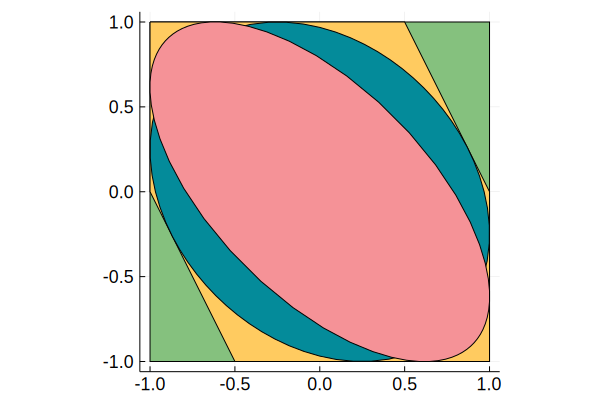

In [11]:
plot(ratio=:equal, tickfont=Plots.font(12))
plot!(□, color=lichen)
plot!(mci, color=aurore)
plot!(ell, color=canard)
plot!(S2, color=red)
#_savefig("Ellipsoid", "png")

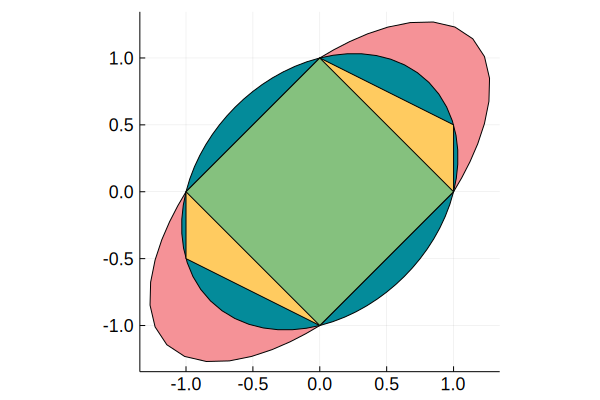

In [12]:
plot(ratio=:equal, tickfont=Plots.font(12))
plot!(SetProg.Sets.polar(S2), color=red)
plot!(SetProg.Sets.polar(ell), color=canard)
plot!(polar_mci, color=aurore)
plot!(polar_□, color=lichen)
#_savefig("PolarEllipsoid", "png")

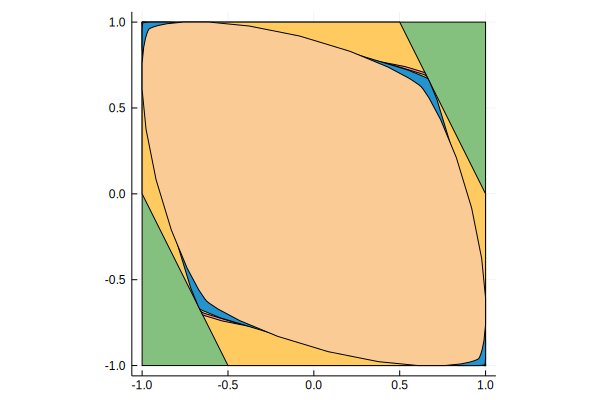

In [13]:
plot(ratio=:equal)
plot!(□, color=lichen)
plot!(mci, color=aurore)
#plot!([-1.0, -0.5], [0.0, -1.0], linewidth=3, color=:black)
#plot!([1.0, 0.5], [0.0, 1.0], linewidth=3, color=:black)
plot!(S22, color=red)
plot!(S18, color=gre)
plot!(S8, color=blu)
#Plots.annotate!(0.8, 0.7, Plots.text("8", fontsize))
plot!(S4, color=ora)
#Plots.annotate!(1.1, -0.7, Plots.text("4", fontsize))
#_savefig("PolySet", "png")

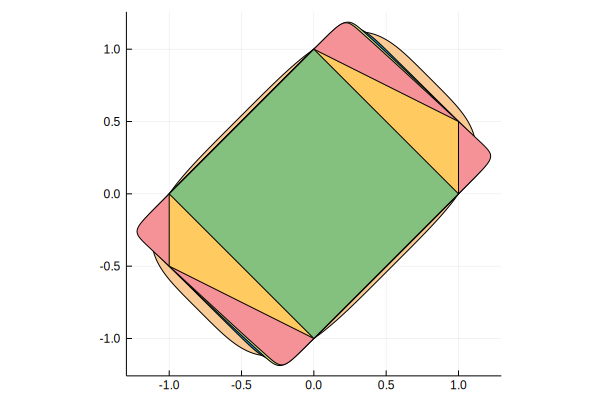

In [14]:
plot(ratio=:equal)
npoints = 512
plot!(SetProg.Sets.polar(S4), color=ora, npoints=npoints)
plot!(SetProg.Sets.polar(S8), color=blu, npoints=npoints)
plot!(SetProg.Sets.polar(S18), color=gre, npoints=npoints)
plot!(SetProg.Sets.polar(S22), color=red, npoints=npoints)
plot!(polar_mci, color=aurore)
plot!(polar_□, color=lichen)
#plot!([-1.0, 0.0], [0.0, -1.0], linewidth=3, color=:black)
#plot!([1.0, 0.0], [0.0, 1.0], linewidth=3, color=:black)
#_savefig("PolarPolySet", "png")

Mosek gives SlowProgress and returns a objective value of 24391 which is worse than for degree 22.

In [15]:
S24 = Sd(24)

  0.751378 seconds (1.32 M allocations: 66.703 MiB, 4.66% gc time)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 206502.07098128332


SetProg.Sets.Polar{Float64,SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}}(SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}(24, SumOfSquares.GramMatrix{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([1.0 -11.9999 … 1.17134 -0.0415884; -11.9999 201.18 … -15.823 1.13142; … ; 1.17134 -15.823 … 206.473 -11.9989; -0.0415884 1.13142 … -11.9989 1.0], DynamicPolynomials.Monomial{true}[x₁¹², x₁¹¹x₂, x₁¹⁰x₂², x₁⁹x₂³, x₁⁸x₂⁴, x₁⁷x₂⁵, x₁⁶x₂⁶, x₁⁵x₂⁷, x₁⁴x₂⁸, x₁³x₂⁹, x₁²x₂¹⁰, x₁x₂¹¹, x₂¹²]), [552.0 -551.995 … -90.8867 91.0194; -551.995 552.005 … 90.89 -91.0277; … ; -90.8867 90.89 … 552.062 -551.951; 91.0194 -91.0277 … -551.951 552.0]))

We can see by plotting that indeed for degree 24, it is worse than for degree 22, it is loosing ground on the top left and bottom right corners. Probably because of the SlowProgress status.

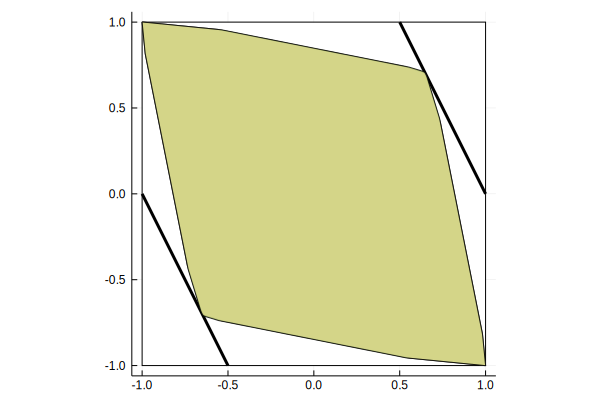

In [16]:
using Plots
include("colors.jl")
plot(□, ratio=:equal, color=:white)
plot!([-1.0, -0.5], [0.0, -1.0], linewidth=3, color=:black)
plot!([1.0, 0.5], [0.0, 1.0], linewidth=3, color=:black)
plot!(S22, color=red, alpha=0.8)
plot!(S24, color=gre, alpha=0.8)

For higher degree, same remark than for degree 24.

In [17]:
S26 = Sd(26)

  0.067977 seconds (42.34 k allocations: 3.150 MiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 710168.8779196889


SetProg.Sets.Polar{Float64,SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}}(SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}(26, SumOfSquares.GramMatrix{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([1.0 -12.9999 … -0.622238 -0.0132265; -12.9999 235.229 … 22.8232 -0.574644; … ; -0.622238 22.8232 … 243.705 -12.9994; -0.0132265 -0.574644 … -12.9994 1.0], DynamicPolynomials.Monomial{true}[x₁¹³, x₁¹²x₂, x₁¹¹x₂², x₁¹⁰x₂³, x₁⁹x₂⁴, x₁⁸x₂⁵, x₁⁷x₂⁶, x₁⁶x₂⁷, x₁⁵x₂⁸, x₁⁴x₂⁹, x₁³x₂¹⁰, x₁²x₂¹¹, x₁x₂¹², x₂¹³]), [650.0 -649.997 … 8.49203 -8.48022; -649.997 650.002 … -8.54508 8.52887; … ; 8.49203 -8.54508 … 650.043 -649.969; -8.48022 8.52887 … -649.969 650.0]))

In [18]:
S28 = Sd(28)

  0.076762 seconds (47.12 k allocations: 3.551 MiB)
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.objective_value(model) = 2.4683800035181437e6


SetProg.Sets.Polar{Float64,SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}}(SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}(28, SumOfSquares.GramMatrix{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([0.999998 -13.9998 … -0.583071 0.049047; -13.9998 275.317 … -6.33905 -0.576582; … ; -0.583071 -6.33905 … 285.133 -13.9995; 0.049047 -0.576582 … -13.9995 0.999998], DynamicPolynomials.Monomial{true}[x₁¹⁴, x₁¹³x₂, x₁¹²x₂², x₁¹¹x₂³, x₁¹⁰x₂⁴, x₁⁹x₂⁵, x₁⁸x₂⁶, x₁⁷x₂⁷, x₁⁶x₂⁸, x₁⁵x₂⁹, x₁⁴x₂¹⁰, x₁³x₂¹¹, x₁²x₂¹², x₁x₂¹³, x₂¹⁴]), [755.998 -755.992 … 5.2523 -5.31636; -755.992 756.002 … -5.25704 5.31822; … ; 5.2523 -5.25704 … 756.037 -755.971; -5.31636 5.31822 … -755.971 755.998]))

In [19]:
S30 = Sd(30)

  0.081223 seconds (52.15 k allocations: 3.964 MiB)
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.objective_value(model) = 8.656903723708555e6


SetProg.Sets.Polar{Float64,SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}}(SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}(30, SumOfSquares.GramMatrix{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([0.999945 -14.9968 … 1.02175 -0.0162269; -14.9968 321.969 … -22.8723 0.931194; … ; 1.02175 -22.8723 … 342.673 -14.9939; -0.0162269 0.931194 … -14.9939 0.999943], DynamicPolynomials.Monomial{true}[x₁¹⁵, x₁¹⁴x₂, x₁¹³x₂², x₁¹²x₂³, x₁¹¹x₂⁴, x₁¹⁰x₂⁵, x₁⁹x₂⁶, x₁⁸x₂⁷, x₁⁷x₂⁸, x₁⁶x₂⁹, x₁⁵x₂¹⁰, x₁⁴x₂¹¹, x₁³x₂¹², x₁²x₂¹³, x₁x₂¹⁴, x₂¹⁵]), [869.952 -869.813 … 50.1406 -50.0632; -869.813 869.942 … -50.4884 50.3297; … ; 50.1406 -50.4884 … 870.151 -869.648; -50.0632 50.3297 … -869.648 869.95]))

In [20]:
S32 = Sd(32)

  0.098072 seconds (57.47 k allocations: 4.461 MiB)
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.objective_value(model) = 3.0613426681183808e7


SetProg.Sets.Polar{Float64,SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}}(SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}(32, SumOfSquares.GramMatrix{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([0.999943 -15.9962 … 0.072386 -0.0291201; -15.9962 372.055 … 17.7979 0.112096; … ; 0.072386 17.7979 … 399.759 -15.9927; -0.0291201 0.112096 … -15.9927 0.999942], DynamicPolynomials.Monomial{true}[x₁¹⁶, x₁¹⁵x₂, x₁¹⁴x₂², x₁¹³x₂³, x₁¹²x₂⁴, x₁¹¹x₂⁵, x₁¹⁰x₂⁶, x₁⁹x₂⁷, x₁⁸x₂⁸, x₁⁷x₂⁹, x₁⁶x₂¹⁰, x₁⁵x₂¹¹, x₁⁴x₂¹², x₁³x₂¹³, x₁²x₂¹⁴, x₁x₂¹⁵, x₂¹⁶]), [991.943 -991.762 … -15.8122 15.3731; -991.762 991.967 … 15.3041 -14.8832; … ; -15.8122 15.3041 … 992.281 -991.55; 15.3731 -14.8832 … -991.55 991.942]))